# When To Invest?

I was wondering how import is timing when making an investment particularly if you have a longer holding period.

We are going to use the data from the the Federal Reserve Bank of St. Louis website more commonly known as FRED. There is a handy function available in the pandas module that will allow us to get the data directly and put it into a DataFrame.

In [1]:
%matplotlib inline

import datetime as dt
import json
import os
import urllib.request
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
fred_api = '911af07bfc0e71f59627da4dc0203487'

In [2]:
def get_fed(data_id: str, start_date: str=None, end_date: str=None) -> pd.DataFrame:
    """
    get_fed can be a model for other json requests. The req string can be built
    to suit other api purposes. The creation of the DataFrame may require only a 
    change in the name of the column from observations to something appropriate
    
    Parameters
    ----------
    data_id: str
        The name of the data item from the FRED. Example SP500 for the S&P 500.
    start_date: str
        Data start date in the format of %Y-%m-%d, e.g. 2015-12-31. The default
        start date is 10 years prior to the current day.
    end_date: str
        Data end date in the format of %Y-%m-%d, e.g. 2015-12-31. The default
        end date is today.
        
    Returns
    -------
    df: pandas DataFrame
    """
    filename = data_id + '.csv'
    if start_date is None:
        start_date = (dt.datetime.today() - dt.timedelta(days=3650)).strftime('%Y-%m-%d')
    if end_date is None:
        end_date = dt.datetime.today().strftime('%Y-%m-%d')
    if not os.path.exists(filename) or stale_file(filename, 7):
        ACCESS_KEY = '911af07bfc0e71f59627da4dc0203487'
        req = urllib.request.urlopen('https://api.stlouisfed.org/fred/series/observations'
                                     + '?series_id=' + data_id
                                     + '&observation_start=' + start_date
                                     + '&observation_end=' + end_date
                                     + '&api_key=' + ACCESS_KEY
                                     + '&file_type=json').read().decode('utf-8')
        df = pd.DataFrame(json.loads(req)['observations'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')  # 'value' is an object
        df = df.set_index(pd.to_datetime(df['date']))
        df.rename(columns={'value' : data_id}, inplace=True)
        df.to_csv(data_id + '.csv')
        return df[[data_id]]
    else:
        return(pd.read_csv(data_id+'.csv', index_col=0, parse_dates=True))
    

def stale_file(filename: str, age_limit: int) -> bool:
    """
    Checks to see if a file is stale
    
    Parameters
    ----------
    filename: str
    age_limit: int
        The maximum age in days before a file is considered stale
    
    Returns
    -------
    True if the file is stale or False if it isn't
    """
    m_date = dt.datetime.fromtimestamp(os.stat('SP500.csv')
                                       .st_mtime).strftime('%Y%m%d')
    today = dt.datetime.today().strftime('%Y%m%d')
    if (dt.datetime.today() 
        - dt.datetime.fromtimestamp(os.stat(filename).st_mtime)).days > age_limit:
        return True

In [3]:
data_id, start_date = 'SP500', '1999-12-31'
df = get_fed(data_id, start_date)
df.head()

,SP500
date,
2008-09-02,1277.58
2008-09-03,1274.98
2008-09-04,1236.83
2008-09-05,1242.31
2008-09-08,1267.79


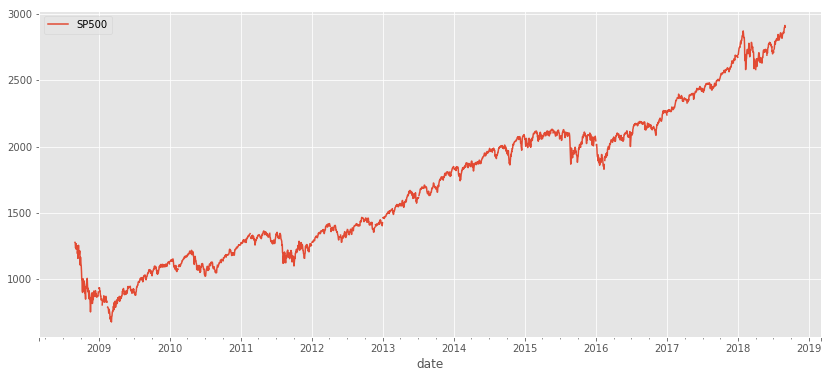

In [4]:
df.plot(figsize=(14,6));

We have 10 years of daily data. Now we want to get the month end index levels and from those we will calculate calendar monthly returns.

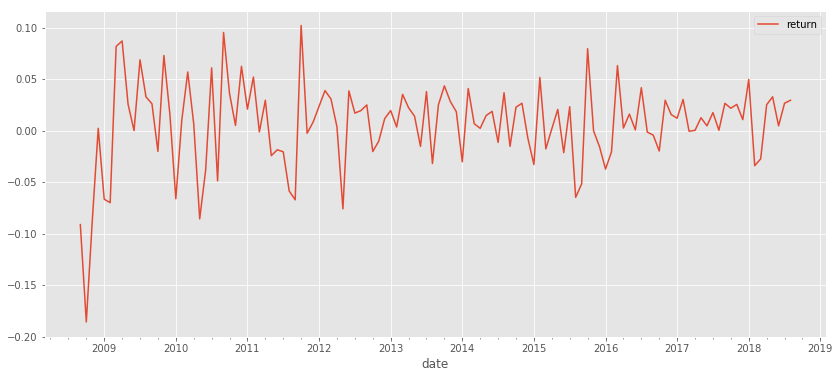

In [5]:
df['return'] = np.log(df[data_id]) - np.log(df[data_id].shift(1))
monthly = df[['return']].resample('M').sum()
monthly.plot(figsize=(14,6));

## Rolling 1 Year Return or When Should I Buy?

This seems to imply that most of the time you can buy the S&P 500 and in a year, you will still have a postive return. We can calculate the proportion of positive 1 year holding periods to negative 1 year holding periods.

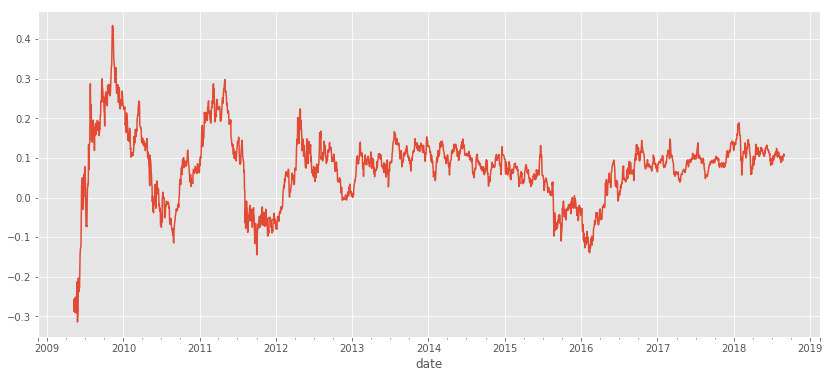

In [6]:
df['1 yr return'] = df['return'].resample('D').sum().rolling(250).sum()
df['1 yr return'].plot(figsize=(14,6));

In [7]:
for ret in range(12):
    print('Exp return: {:0.1%} Probability: {:0.2%}'.format(ret/100, len(df[df['1 yr return'] > ret/100]) /
          (len(df[df['1 yr return'] > ret/100]) + len(df[df['1 yr return'] < ret/100]))))

Exp return: 0.0% Probability: 82.21%
Exp return: 1.0% Probability: 80.53%
Exp return: 2.0% Probability: 79.25%
Exp return: 3.0% Probability: 77.56%
Exp return: 4.0% Probability: 75.13%
Exp return: 5.0% Probability: 71.59%
Exp return: 6.0% Probability: 67.35%
Exp return: 7.0% Probability: 61.59%
Exp return: 8.0% Probability: 54.67%
Exp return: 9.0% Probability: 46.73%
Exp return: 10.0% Probability: 38.25%
Exp return: 11.0% Probability: 29.64%
